### Importing Necessary Libraries

In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAvgPool2D, BatchNormalization
# from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import precision_recall_fscore_support as score

## Data

A detailed discussion and visualization of the data can be seen in [here](Data-Overview.ipynb).

In [2]:
labels = pd.read_csv("./Data/train_labels.csv")
images = ['./Data/train/train/'+str(name)+'.tif' for name in labels['id']]
labels['images'] = images
labels = labels[['id', 'images', 'label']]

In [3]:
labels

,id,images,label
0,0,./Data/train/train/0.tif,1
1,1,./Data/train/train/1.tif,13
2,2,./Data/train/train/2.tif,13
3,3,./Data/train/train/3.tif,14
4,4,./Data/train/train/4.tif,6
...,...,...,...
15995,15995,./Data/train/train/15995.tif,2
15996,15996,./Data/train/train/15996.tif,15
15997,15997,./Data/train/train/15997.tif,3
15998,15998,./Data/train/train/15998.tif,9


In [4]:
train_labels = pd.read_csv('./Data/train_labels_1.csv')
test_labels = pd.read_csv('./Data/test_labels_1.csv')

In [5]:
train_labels

,id,images,label
0,0,./Data/train/train/0.tif,1
1,1,./Data/train/train/1.tif,13
2,2,./Data/train/train/2.tif,13
3,3,./Data/train/train/3.tif,14
4,4,./Data/train/train/4.tif,6
...,...,...,...
15195,15995,./Data/train/train/15995.tif,2
15196,15996,./Data/train/train/15996.tif,15
15197,15997,./Data/train/train/15997.tif,3
15198,15998,./Data/train/train/15998.tif,9


In [6]:
test_labels

,id,images,label
0,18,./Data/train/train/18.tif,11
1,25,./Data/train/train/25.tif,8
2,33,./Data/train/train/33.tif,6
3,41,./Data/train/train/41.tif,1
4,65,./Data/train/train/65.tif,14
...,...,...,...
795,15816,./Data/train/train/15816.tif,2
796,15824,./Data/train/train/15824.tif,2
797,15832,./Data/train/train/15832.tif,11
798,15863,./Data/train/train/15863.tif,15


In [7]:
class_labels = list(set(labels['label']))
class_names = [
    'letter', 'form', 'email', 'handwritten', 'advertisement', 'scientific report', 'scientific publication',
    'specification', 'file folder', 'news article', 'budget', 'invoice', 'presentation', 'questionnaire', 'resume',
    'memo'
]
label_names = pd.DataFrame({
    'labels': class_labels,
    'names': class_names
})

## Data Preparation

We have already generated the Extracted Feature Vectors from the ResNet Model now we train using that, so we load those feature vectors.

In [8]:
FEATURE_DIM = 512

In [9]:
fine_tune_data = np.concatenate([np.transpose(np.load(f'./Data/VGG16-4P-train-precompute/train_data_precomp-{idx}.npy'), (1,0,2)) for idx in range(10)])
np.save(f'./Data/VGG16-4P-train-precompute/whole_train_data_precomp.npy', fine_tune_data)
fine_tune_data.shape

(16000, 5, 512)

In [10]:
fine_tune_data = np.load('./Data/VGG16-4P-train-precompute/whole_train_data_precomp.npy')
fine_tune_data.shape

(16000, 5, 512)

In [11]:
fine_tune_labels = labels['label'].to_numpy()
fine_tune_labels.shape

(16000,)

In [12]:
fine_tune_data_train = fine_tune_data[list(train_labels['id'])]
fine_tune_data_train.shape

(15200, 5, 512)

In [13]:
fine_tune_labels_train = train_labels['label'].to_numpy()
fine_tune_labels_train.shape

(15200,)

In [14]:
fine_tune_data_test = fine_tune_data[list(test_labels['id'])]
fine_tune_data_test.shape

(800, 5, 512)

In [15]:
fine_tune_labels_test = test_labels['label'].to_numpy()
fine_tune_labels_test.shape

(800,)

## Fine-Tuning Models

The fine-tuning part of our model.

In [16]:
def ftmodel():
    inputs = Input(shape=(5, FEATURE_DIM))
    x = Flatten()(inputs)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.5
    # x = Dropout(top_dropout_rate, name='top_dropout_1')(x)
    # x = Dense(1024, name='top_dense_1', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    # x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_2')(x)
    x = Dense(512, name='top_dense_2', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_3')(x)
    outputs = Dense(16, activation='softmax', name='pred', kernel_regularizer=l2(5e-5))(x)

    model1 = tf.keras.Model(inputs, outputs, name='VGG16-FineTune')
    return model1

In [17]:
model1 = ftmodel()
model1.summary()

Metal device set to: Apple M1 Max
Model: "VGG16-FineTune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 512)]          0         
                                                                 
 flatten (Flatten)           (None, 2560)              0         
                                                                 
 batch_normalization (BatchN  (None, 2560)             10240     
 ormalization)                                                   
                                                                 
 top_dropout_2 (Dropout)     (None, 2560)              0         
                                                                 
 top_dense_2 (Dense)         (None, 512)               1311232   
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)  

2022-10-09 17:05:43.202464: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-09 17:05:43.202559: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Model Training

The fine-tuning will be done on the VGG16's $512D$ representation vectors.

In [18]:
model1.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate = 0.0003))

In [19]:
EPOCHS = 1000
checkpoint_filepaths = ['./Models/VGG16-4P/auto-VGG16-FT-model-weight']
model_checkpoint_callback = [tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor = "loss",
    mode='min',
    save_best_only=True) for checkpoint_filepath in checkpoint_filepaths]

In [20]:
history = model1.fit(fine_tune_data_train, fine_tune_labels_train, epochs=EPOCHS, batch_size=800, validation_data=(fine_tune_data_test, fine_tune_labels_test), validation_batch_size=800, callbacks=[model_checkpoint_callback])
model1.save_weights("./Models/VGG16-4P/effnet-4p-model-weights")
model1.load_weights('./Models/VGG16-4P/effnet-4p-model-weights')

Epoch 1/1000


2022-10-09 17:05:43.330045: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-09 17:05:43.588093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 1s 30ms/step - loss: 2.9157 - accuracy: 0.2417 - val_loss: 2.5390 - val_accuracy: 0.3162
Epoch 2/1000
 7/19 [==========>...................] - ETA: 0s - loss: 2.2653 - accuracy: 0.3982

2022-10-09 17:05:44.217221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 0s 12ms/step - loss: 2.1614 - accuracy: 0.4213 - val_loss: 2.0234 - val_accuracy: 0.4212
Epoch 3/1000
19/19 [==============================] - 0s 12ms/step - loss: 1.8901 - accuracy: 0.4824 - val_loss: 1.7130 - val_accuracy: 0.5100
Epoch 4/1000
19/19 [==============================] - 0s 13ms/step - loss: 1.7489 - accuracy: 0.5173 - val_loss: 1.5601 - val_accuracy: 0.5625
Epoch 5/1000
19/19 [==============================] - 0s 13ms/step - loss: 1.6289 - accuracy: 0.5425 - val_loss: 1.4454 - val_accuracy: 0.6100
Epoch 6/1000
19/19 [==============================] - 0s 12ms/step - loss: 1.5433 - accuracy: 0.5646 - val_loss: 1.3630 - val_accuracy: 0.6362
Epoch 7/1000
19/19 [==============================] - 0s 12ms/step - loss: 1.4789 - accuracy: 0.5781 - val_loss: 1.2957 - val_accuracy: 0.6463
Epoch 8/1000
19/19 [==============================] - 0s 15ms/step - loss: 1.4227 - accuracy: 0.5922 - val_loss: 1.2461 - val_accuracy: 0.6662
Epoch 9/1000

19/19 [==============================] - 0s 13ms/step - loss: 0.7287 - accuracy: 0.7838 - val_loss: 0.9114 - val_accuracy: 0.7537
Epoch 60/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.7259 - accuracy: 0.7874 - val_loss: 0.9060 - val_accuracy: 0.7487
Epoch 61/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.7279 - accuracy: 0.7877 - val_loss: 0.9166 - val_accuracy: 0.7475
Epoch 62/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.7128 - accuracy: 0.7954 - val_loss: 0.9096 - val_accuracy: 0.7512
Epoch 63/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.7083 - accuracy: 0.7935 - val_loss: 0.9044 - val_accuracy: 0.7600
Epoch 64/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.7150 - accuracy: 0.7897 - val_loss: 0.9106 - val_accuracy: 0.7562
Epoch 65/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.7077 - accuracy: 0.7909 - val_loss: 0.9020 - val_accuracy: 0.7562
Epoch 

19/19 [==============================] - 0s 9ms/step - loss: 0.5072 - accuracy: 0.8551 - val_loss: 0.8902 - val_accuracy: 0.7650
Epoch 117/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.5004 - accuracy: 0.8563 - val_loss: 0.8989 - val_accuracy: 0.7675
Epoch 118/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.4982 - accuracy: 0.8588 - val_loss: 0.8913 - val_accuracy: 0.7700
Epoch 119/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.4831 - accuracy: 0.8634 - val_loss: 0.9019 - val_accuracy: 0.7612
Epoch 120/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.4868 - accuracy: 0.8634 - val_loss: 0.8936 - val_accuracy: 0.7625
Epoch 121/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.4882 - accuracy: 0.8599 - val_loss: 0.8954 - val_accuracy: 0.7650
Epoch 122/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.4874 - accuracy: 0.8618 - val_loss: 0.9055 - val_accuracy: 0.7612
Epoc

19/19 [==============================] - 0s 10ms/step - loss: 0.3726 - accuracy: 0.8983 - val_loss: 0.9184 - val_accuracy: 0.7537
Epoch 173/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.3636 - accuracy: 0.9003 - val_loss: 0.9331 - val_accuracy: 0.7537
Epoch 174/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.3612 - accuracy: 0.9026 - val_loss: 0.9278 - val_accuracy: 0.7500
Epoch 175/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.3618 - accuracy: 0.9039 - val_loss: 0.9332 - val_accuracy: 0.7562
Epoch 176/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.3614 - accuracy: 0.9027 - val_loss: 0.9322 - val_accuracy: 0.7637
Epoch 177/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.3650 - accuracy: 0.9038 - val_loss: 0.9259 - val_accuracy: 0.7575
Epoch 178/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.3674 - accuracy: 0.9003 - val_loss: 0.9339 - val_accuracy: 0.7675


19/19 [==============================] - 0s 14ms/step - loss: 0.2914 - accuracy: 0.9277 - val_loss: 0.9739 - val_accuracy: 0.7612
Epoch 229/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.2956 - accuracy: 0.9255 - val_loss: 0.9609 - val_accuracy: 0.7625
Epoch 230/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.2965 - accuracy: 0.9232 - val_loss: 0.9665 - val_accuracy: 0.7612
Epoch 231/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.2963 - accuracy: 0.9263 - val_loss: 0.9664 - val_accuracy: 0.7650
Epoch 232/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.2902 - accuracy: 0.9228 - val_loss: 0.9537 - val_accuracy: 0.7637
Epoch 233/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.2933 - accuracy: 0.9251 - val_loss: 0.9623 - val_accuracy: 0.7587
Epoch 234/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.2880 - accuracy: 0.9273 - val_loss: 0.9739 - val_accuracy: 0.7575


19/19 [==============================] - 0s 14ms/step - loss: 0.2554 - accuracy: 0.9396 - val_loss: 0.9962 - val_accuracy: 0.7637
Epoch 285/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.2596 - accuracy: 0.9391 - val_loss: 1.0037 - val_accuracy: 0.7587
Epoch 286/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.2480 - accuracy: 0.9424 - val_loss: 0.9951 - val_accuracy: 0.7662
Epoch 287/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.2507 - accuracy: 0.9408 - val_loss: 0.9937 - val_accuracy: 0.7650
Epoch 288/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.2551 - accuracy: 0.9368 - val_loss: 1.0037 - val_accuracy: 0.7650
Epoch 289/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.2569 - accuracy: 0.9398 - val_loss: 1.0118 - val_accuracy: 0.7625
Epoch 290/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.2500 - accuracy: 0.9411 - val_loss: 0.9986 - val_accuracy: 0.7675


19/19 [==============================] - 0s 15ms/step - loss: 0.2229 - accuracy: 0.9517 - val_loss: 1.0180 - val_accuracy: 0.7562
Epoch 341/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.2325 - accuracy: 0.9472 - val_loss: 1.0151 - val_accuracy: 0.7562
Epoch 342/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.2325 - accuracy: 0.9463 - val_loss: 1.0093 - val_accuracy: 0.7637
Epoch 343/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.2290 - accuracy: 0.9483 - val_loss: 1.0265 - val_accuracy: 0.7600
Epoch 344/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.2248 - accuracy: 0.9485 - val_loss: 1.0160 - val_accuracy: 0.7675
Epoch 345/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.2208 - accuracy: 0.9491 - val_loss: 1.0190 - val_accuracy: 0.7587
Epoch 346/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.2236 - accuracy: 0.9489 - val_loss: 1.0191 - val_accuracy: 0.7612
E

19/19 [==============================] - 0s 11ms/step - loss: 0.2120 - accuracy: 0.9530 - val_loss: 1.0320 - val_accuracy: 0.7625
Epoch 397/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.2051 - accuracy: 0.9551 - val_loss: 1.0284 - val_accuracy: 0.7600
Epoch 398/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.2081 - accuracy: 0.9549 - val_loss: 1.0236 - val_accuracy: 0.7612
Epoch 399/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.2063 - accuracy: 0.9547 - val_loss: 1.0145 - val_accuracy: 0.7612
Epoch 400/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.2053 - accuracy: 0.9540 - val_loss: 1.0324 - val_accuracy: 0.7625
Epoch 401/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.2108 - accuracy: 0.9553 - val_loss: 1.0367 - val_accuracy: 0.7637
Epoch 402/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.2072 - accuracy: 0.9555 - val_loss: 1.0426 - val_accuracy: 0.7612
E

19/19 [==============================] - 0s 11ms/step - loss: 0.2024 - accuracy: 0.9575 - val_loss: 1.0625 - val_accuracy: 0.7625
Epoch 453/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1927 - accuracy: 0.9613 - val_loss: 1.0490 - val_accuracy: 0.7625
Epoch 454/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.1947 - accuracy: 0.9592 - val_loss: 1.0621 - val_accuracy: 0.7575
Epoch 455/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1933 - accuracy: 0.9579 - val_loss: 1.0550 - val_accuracy: 0.7625
Epoch 456/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1982 - accuracy: 0.9581 - val_loss: 1.0529 - val_accuracy: 0.7662
Epoch 457/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1981 - accuracy: 0.9580 - val_loss: 1.0641 - val_accuracy: 0.7575
Epoch 458/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.1930 - accuracy: 0.9605 - val_loss: 1.0677 - val_accuracy: 0.7562
E

19/19 [==============================] - 0s 11ms/step - loss: 0.1908 - accuracy: 0.9607 - val_loss: 1.1030 - val_accuracy: 0.7475
Epoch 509/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1901 - accuracy: 0.9609 - val_loss: 1.0975 - val_accuracy: 0.7512
Epoch 510/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1897 - accuracy: 0.9626 - val_loss: 1.1112 - val_accuracy: 0.7562
Epoch 511/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1901 - accuracy: 0.9627 - val_loss: 1.1051 - val_accuracy: 0.7562
Epoch 512/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1857 - accuracy: 0.9634 - val_loss: 1.1012 - val_accuracy: 0.7550
Epoch 513/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.1824 - accuracy: 0.9651 - val_loss: 1.0872 - val_accuracy: 0.7637
Epoch 514/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1854 - accuracy: 0.9628 - val_loss: 1.0844 - val_accuracy: 0.7650


19/19 [==============================] - 0s 12ms/step - loss: 0.1870 - accuracy: 0.9620 - val_loss: 1.0962 - val_accuracy: 0.7562
Epoch 565/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.1817 - accuracy: 0.9652 - val_loss: 1.1009 - val_accuracy: 0.7637
Epoch 566/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1772 - accuracy: 0.9662 - val_loss: 1.1142 - val_accuracy: 0.7675
Epoch 567/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1831 - accuracy: 0.9632 - val_loss: 1.1117 - val_accuracy: 0.7637
Epoch 568/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1782 - accuracy: 0.9682 - val_loss: 1.1271 - val_accuracy: 0.7625
Epoch 569/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1823 - accuracy: 0.9643 - val_loss: 1.1274 - val_accuracy: 0.7612
Epoch 570/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1835 - accuracy: 0.9651 - val_loss: 1.1210 - val_accuracy: 0.7625


19/19 [==============================] - 0s 12ms/step - loss: 0.1718 - accuracy: 0.9680 - val_loss: 1.1200 - val_accuracy: 0.7600
Epoch 621/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1791 - accuracy: 0.9635 - val_loss: 1.1155 - val_accuracy: 0.7637
Epoch 622/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1812 - accuracy: 0.9666 - val_loss: 1.0966 - val_accuracy: 0.7612
Epoch 623/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1725 - accuracy: 0.9674 - val_loss: 1.0937 - val_accuracy: 0.7650
Epoch 624/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1804 - accuracy: 0.9650 - val_loss: 1.0840 - val_accuracy: 0.7625
Epoch 625/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1742 - accuracy: 0.9673 - val_loss: 1.0959 - val_accuracy: 0.7675
Epoch 626/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1790 - accuracy: 0.9655 - val_loss: 1.0913 - val_accuracy: 0.7688


19/19 [==============================] - 0s 11ms/step - loss: 0.1768 - accuracy: 0.9674 - val_loss: 1.1148 - val_accuracy: 0.7675
Epoch 677/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1698 - accuracy: 0.9702 - val_loss: 1.1205 - val_accuracy: 0.7650
Epoch 678/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1710 - accuracy: 0.9684 - val_loss: 1.1299 - val_accuracy: 0.7587
Epoch 679/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.1626 - accuracy: 0.9697 - val_loss: 1.1260 - val_accuracy: 0.7575
Epoch 680/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1696 - accuracy: 0.9693 - val_loss: 1.1297 - val_accuracy: 0.7562
Epoch 681/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1670 - accuracy: 0.9714 - val_loss: 1.1349 - val_accuracy: 0.7637
Epoch 682/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1782 - accuracy: 0.9672 - val_loss: 1.1424 - val_accuracy: 0.7587


19/19 [==============================] - 0s 11ms/step - loss: 0.1708 - accuracy: 0.9691 - val_loss: 1.1483 - val_accuracy: 0.7612
Epoch 733/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1670 - accuracy: 0.9694 - val_loss: 1.1356 - val_accuracy: 0.7612
Epoch 734/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1640 - accuracy: 0.9709 - val_loss: 1.1208 - val_accuracy: 0.7612
Epoch 735/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1684 - accuracy: 0.9703 - val_loss: 1.1188 - val_accuracy: 0.7637
Epoch 736/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1733 - accuracy: 0.9655 - val_loss: 1.1182 - val_accuracy: 0.7763
Epoch 737/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1707 - accuracy: 0.9699 - val_loss: 1.1083 - val_accuracy: 0.7650
Epoch 738/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1666 - accuracy: 0.9697 - val_loss: 1.1245 - val_accuracy: 0.7675


19/19 [==============================] - 0s 15ms/step - loss: 0.1628 - accuracy: 0.9721 - val_loss: 1.1475 - val_accuracy: 0.7587
Epoch 789/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1633 - accuracy: 0.9714 - val_loss: 1.1473 - val_accuracy: 0.7587
Epoch 790/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1602 - accuracy: 0.9726 - val_loss: 1.1520 - val_accuracy: 0.7575
Epoch 791/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1655 - accuracy: 0.9715 - val_loss: 1.1474 - val_accuracy: 0.7575
Epoch 792/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1676 - accuracy: 0.9709 - val_loss: 1.1424 - val_accuracy: 0.7600
Epoch 793/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1604 - accuracy: 0.9726 - val_loss: 1.1516 - val_accuracy: 0.7587
Epoch 794/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1695 - accuracy: 0.9693 - val_loss: 1.1576 - val_accuracy: 0.7525


19/19 [==============================] - 0s 11ms/step - loss: 0.1621 - accuracy: 0.9722 - val_loss: 1.1852 - val_accuracy: 0.7525
Epoch 845/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1649 - accuracy: 0.9714 - val_loss: 1.1840 - val_accuracy: 0.7675
Epoch 846/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1643 - accuracy: 0.9718 - val_loss: 1.1729 - val_accuracy: 0.7587
Epoch 847/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1641 - accuracy: 0.9716 - val_loss: 1.1676 - val_accuracy: 0.7688
Epoch 848/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1622 - accuracy: 0.9728 - val_loss: 1.1854 - val_accuracy: 0.7637
Epoch 849/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1598 - accuracy: 0.9723 - val_loss: 1.1943 - val_accuracy: 0.7587
Epoch 850/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1590 - accuracy: 0.9739 - val_loss: 1.1852 - val_accuracy: 0.7512


19/19 [==============================] - 0s 11ms/step - loss: 0.1562 - accuracy: 0.9744 - val_loss: 1.1760 - val_accuracy: 0.7600
Epoch 901/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1624 - accuracy: 0.9728 - val_loss: 1.1695 - val_accuracy: 0.7688
Epoch 902/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1587 - accuracy: 0.9727 - val_loss: 1.1684 - val_accuracy: 0.7662
Epoch 903/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1598 - accuracy: 0.9720 - val_loss: 1.1725 - val_accuracy: 0.7625
Epoch 904/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1617 - accuracy: 0.9725 - val_loss: 1.1741 - val_accuracy: 0.7587
Epoch 905/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.1537 - accuracy: 0.9755 - val_loss: 1.1891 - val_accuracy: 0.7675
Epoch 906/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1665 - accuracy: 0.9721 - val_loss: 1.1957 - val_accuracy: 0.7650


19/19 [==============================] - 0s 10ms/step - loss: 0.1609 - accuracy: 0.9730 - val_loss: 1.1647 - val_accuracy: 0.7688
Epoch 957/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1600 - accuracy: 0.9726 - val_loss: 1.1546 - val_accuracy: 0.7675
Epoch 958/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1608 - accuracy: 0.9728 - val_loss: 1.1694 - val_accuracy: 0.7713
Epoch 959/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1606 - accuracy: 0.9716 - val_loss: 1.1693 - val_accuracy: 0.7612
Epoch 960/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1573 - accuracy: 0.9725 - val_loss: 1.1629 - val_accuracy: 0.7575
Epoch 961/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1569 - accuracy: 0.9724 - val_loss: 1.1649 - val_accuracy: 0.7637
Epoch 962/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1574 - accuracy: 0.9746 - val_loss: 1.1755 - val_accuracy: 0.7650


In [43]:
model1.load_weights('./Models/VGG16-4P/auto-VGG16-FT-model-weight')

In [22]:
def plot_train_loss(history, model_name):  
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model_name+' loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train loss', 'train accuracy', 'val loss', 'val accuracy'], loc='upper left')

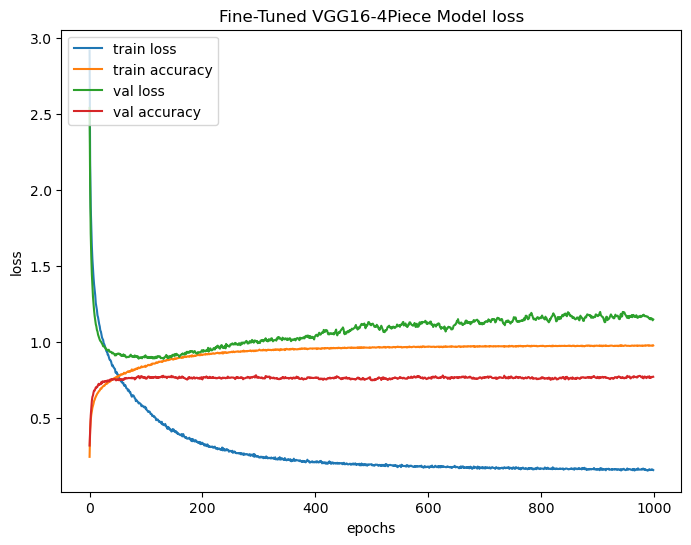

In [23]:
plot_train_loss(history, 'Fine-Tuned VGG16-4Piece Model')

### Model Evaluation

#### On Train Data

Now, after the model is being trained, we will look at the performance of the model on the training set.

In [24]:
train_preds = model1.predict(fine_tune_data_train)

 54/475 [==>...........................] - ETA: 1s

2022-10-09 17:09:31.466043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


475/475 [==============================] - 1s 3ms/step


In [25]:
train_pred_labels = np.argmax(train_preds, axis=-1)

In [26]:
train_pred_labels

array([ 1, 13, 13, ...,  3,  9,  9])

In [27]:
np.sum(train_pred_labels == train_labels['label'])

15197

Looking at the misclassified images to get a better idea about what features the model is unable to capture.

In [28]:
mis_train_data = train_labels[train_pred_labels != train_labels['label']]
mis_train_data

,id,images,label
9198,9682,./Data/train/train/9682.tif,12
12255,12896,./Data/train/train/12896.tif,9
14569,15333,./Data/train/train/15333.tif,7


In [29]:
precision, recall, fscore, support = score(train_labels['label'], train_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,0.997959,1.000000,0.998979,978
1,1.000000,1.000000,1.000000,925
2,1.000000,1.000000,1.000000,925
3,1.000000,1.000000,1.000000,947
4,0.998926,1.000000,0.999463,930
5,1.000000,1.000000,1.000000,962
6,1.000000,1.000000,1.000000,998
7,1.000000,0.998905,0.999452,913
8,1.000000,1.000000,1.000000,1005
9,1.000000,0.998951,0.999475,953


#### On Train-Test Data

In [30]:
test_preds = model1.predict(fine_tune_data_test)

25/25 [==============================] - 0s 4ms/step


In [31]:
test_pred_labels = np.argmax(test_preds, axis=-1)

In [32]:
test_pred_labels

array([11,  8,  6,  7,  1,  6, 13, 12, 14,  1,  6, 15,  0, 14, 13, 11,  0,
        6,  6, 12,  8, 14,  3,  5,  6,  0,  3, 14,  3,  3, 11,  1,  6,  2,
        1,  8,  4, 10, 11,  9,  6, 12, 14,  5,  5, 14,  3,  0, 13,  4,  0,
       10, 13, 15, 11, 14, 15,  9,  9,  2, 15,  9, 10, 11,  6,  8,  8,  0,
        6,  3,  4,  4, 12,  0,  8,  6,  7,  0, 12,  0, 11, 15, 12, 12,  9,
        8,  1, 13, 13, 13, 10, 11,  4, 10,  1, 13, 11,  8, 13, 10,  3, 10,
       12,  9, 11, 14,  8,  2,  5,  8,  7,  7,  9,  4, 12,  9, 12,  1, 11,
        6, 10,  1,  0, 10,  1, 10, 13,  8, 15,  7,  3, 11,  6,  1,  6,  9,
       14, 10,  7, 14, 10,  8,  4, 12,  8, 13,  8,  9,  2, 13, 15, 15,  4,
       14,  4,  9,  4, 14,  7,  7,  8,  4,  4, 12, 13,  8, 15,  3,  8,  8,
       13,  6,  3, 11,  7, 12, 10, 14, 14,  8,  6, 10, 13, 11,  6, 13,  4,
       14, 11,  7, 15,  0,  3,  0, 10, 13, 12, 10, 11, 11,  5,  1,  9,  1,
        9,  5, 13, 15, 12,  1,  4,  8,  7,  6, 13, 12,  4, 12,  8, 15,  9,
       13, 15, 13,  7,  7

In [33]:
np.sum(test_pred_labels == test_labels['label'])

616

In [34]:
mis_train_data = test_labels[test_pred_labels != test_labels['label']]
mis_train_data

,id,images,label
3,41,./Data/train/train/41.tif,1
4,65,./Data/train/train/65.tif,14
5,67,./Data/train/train/67.tif,9
7,100,./Data/train/train/100.tif,10
12,179,./Data/train/train/179.tif,7
...,...,...,...
776,15528,./Data/train/train/15528.tif,5
779,15568,./Data/train/train/15568.tif,9
785,15621,./Data/train/train/15621.tif,15
788,15687,./Data/train/train/15687.tif,12


In [35]:
precision, recall, fscore, support = score(test_labels['label'], test_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,0.689655,0.740741,0.714286,54
1,0.595238,0.568182,0.581395,44
2,0.973684,0.860465,0.913580,43
3,0.934783,0.934783,0.934783,46
4,0.868421,0.916667,0.891892,36
5,0.647059,0.440000,0.523810,50
6,0.795918,0.847826,0.821053,46
7,0.872340,0.788462,0.828283,52
8,0.818182,1.000000,0.900000,54
9,0.800000,0.765957,0.782609,47


In [36]:
np.mean(fscore)

0.7694735070390781

#### On Validation Data

Generating Predictions for the Validation Set

In [37]:
validation_data = pd.DataFrame({'images':['./Data/validation/validation/'+name for name in os.listdir('./Data/validation/validation/')]})
validation_data['id'] = [name.split('.')[0] for name in os.listdir('./Data/validation/validation/')]
validation_data['label'] = -1 # Simply added to prevent re-writing code
validation_data.sort_values(by=['id'], inplace=True)
validation_data

,images,id,label
850,./Data/validation/validation/17801.tif,17801,-1
898,./Data/validation/validation/17802.tif,17802,-1
852,./Data/validation/validation/17803.tif,17803,-1
798,./Data/validation/validation/17804.tif,17804,-1
750,./Data/validation/validation/17805.tif,17805,-1
...,...,...,...
246,./Data/validation/validation/18696.tif,18696,-1
211,./Data/validation/validation/18697.tif,18697,-1
760,./Data/validation/validation/18698.tif,18698,-1
787,./Data/validation/validation/18699.tif,18699,-1


In [38]:
fine_tune_data_validation = np.load('./Data/VGG16-4P-validation-precompute/whole_validation_data_precomp.npy')
fine_tune_data_validation.shape

(900, 5, 512)

In [39]:
valid_preds = model1.predict(fine_tune_data_validation)

29/29 [==============================] - 0s 3ms/step


2022-10-09 17:09:33.239632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [40]:
valid_pred_labels = np.argmax(valid_preds, axis=-1)

### Submission

For Kaggle Submission

In [41]:
submission_data = pd.DataFrame({'id':list(range(17801, 18701))})
submission_data['label'] = valid_pred_labels
submission_data

,id,label
0,17801,4
1,17802,6
2,17803,4
3,17804,8
4,17805,3
...,...,...
895,18696,7
896,18697,12
897,18698,8
898,18699,5


In [42]:
submission_data.to_csv('./Submissions/submission-vgg16-4p.csv', index=False)